In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import json
import base64
from io import BytesIO
import gradio as gr
from PIL import Image

In [2]:
load_dotenv()
openai = OpenAI()
MODEL_NAME = "gpt-4o-mini"

In [3]:
system_prompt = """
You are helpful assistant for an airline company. Give short, courteous answers, no more than 1 sentence. 
Always be accurate. If you don't know the answer, strictly mention the same and DO NOT MAKE INFORMATION UP.
"""

In [4]:
ticket_prices = { "new york": "$200", "delhi":"$300", "london":"$400", "paris":"$500", "tokyo":"$600" }
def get_ticket_price(destination):
    destination = destination.lower()
    price = ticket_prices.get(destination, "Unknown")
    return price


In [5]:
ticket_pricing_tool = {
    "name": "get_ticket_price",
    "description": "Gets the ticket price for given destination. Call this whenever you need to know the ticket price. For example, 'What is the ticket price for London?'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination": {
                "type": "string",
                "description": "The destination city for the ticket price",
            }
        },
        "required": ["destination"],
    },
}

In [6]:
tools = [{"type": "function", "function": ticket_pricing_tool}]

In [7]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    tool_args = json.loads(tool_call.function.arguments)

    if tool_call.function.name == "get_ticket_price":
        destination = tool_args["destination"]
        price = get_ticket_price(destination)
        response = {
            "role": "tool",
            "content": json.dumps({"destination": destination, "price": price}),
            "tool_call_id": tool_call.id,
        }
        return response, destination
    return None
        

In [8]:
def generate_image(destination):
    image_response = openai.images.generate(
        prompt=f"An image representing a vacation in {destination}, showing tourist spots and everything unique about {destination}, in a vibrant style.",
        model="dall-e-3",
        n=1,
        size="1024x1024",
        response_format="b64_json",
    )

    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

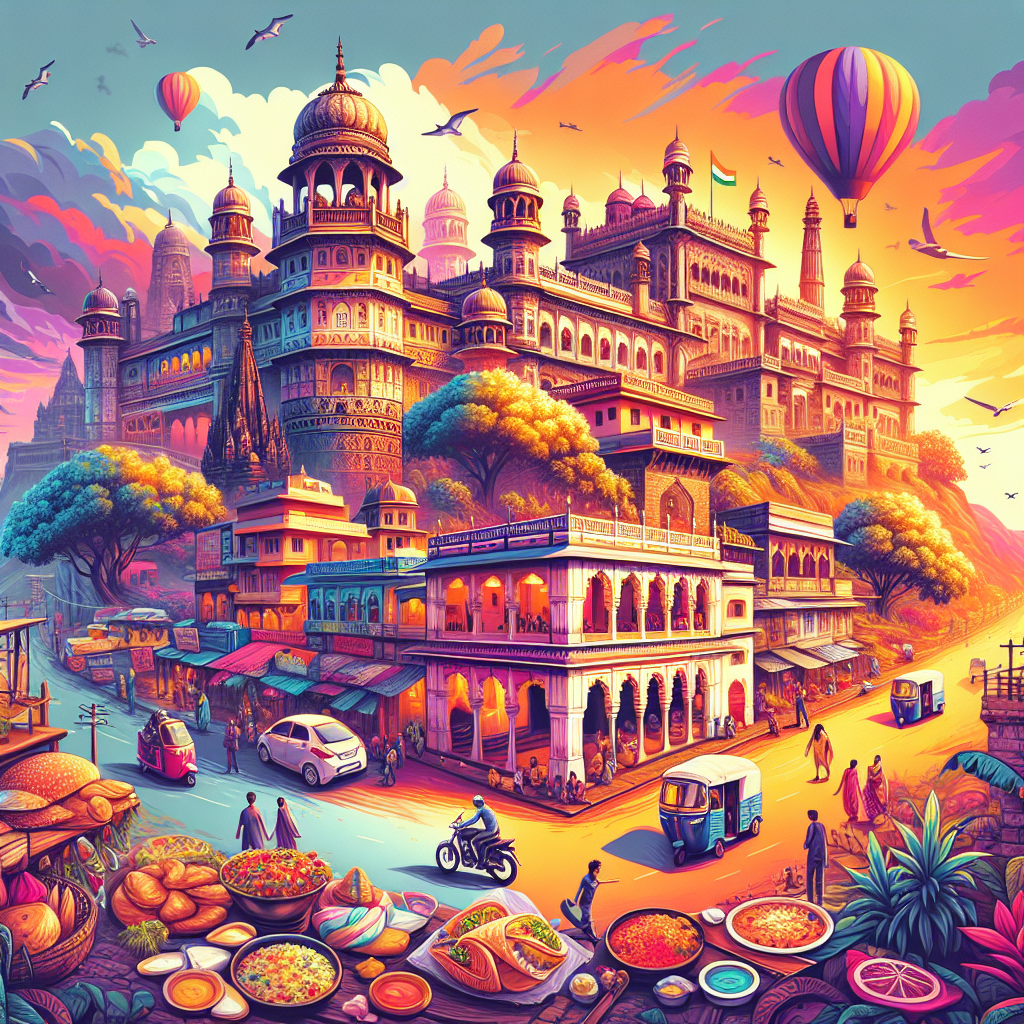

In [9]:
image = generate_image("pune")
display(image)

In [10]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [ ]:
def chat(message, history):
    messages = []
    messages.append({"role": "system", "content": system_prompt})
    for user_message, assistant_message in history:
        messages.append({"role": "user", "content": user_message})
        messages.append({"role": "assistant", "content": assistant_message})
    messages.append({"role": "user", "content": message})

    response = openai.chat.completions.create(
        model = MODEL_NAME,
        messages = messages,
        tools=tools
    )

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, destination = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = generate_image(destination)
        response = openai.chat.completions.create(
            model = MODEL_NAME,
            messages = messages
        )

    reply = response.choices[0].message.content
    # Issue with audio playback on the machine, so commented it out
    #talker(reply)
    return reply     

In [ ]:
# Not for images to show up - you need to use a bit complex gradio implementation. Skipping it for now. 
gr.ChatInterface(fn=chat).launch()

c:\TFS\Study\machine-learning\.venv\lib\site-packages\gradio\chat_interface.py:334: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.
